In [4]:
import sys

sys.path.insert(0, '../src')

from pysycomp import *

In [5]:
time_deriv(p*q, 1)

In [11]:
def time_deriv(var, order = 1):
    """
    Args:
        var: The variable of interest to take the time derivative of. For example, the position or momentum operator.
        order: The order of the exponent of the variable of interest. The default value is 1
        
    Returns:
        The time derivative of the variable of interest to the desired order.
    
    """
    pq_s = Symbol("pq_s")
    aux = f(q)
    pq_s = (Operator(p)*Operator(q)+Operator(q)*Operator(p))/2
    
#    h1 = expand(ham(p, q)*Operator(var**order)*aux-Operator(var**order)*ham(p, q)*aux)
    h1 = expand(Operator(var**order)*ham(p, q)*aux - ham(p, q)*Operator(var**order)*aux)
    
    if var == V:
        der = f'((p)*(Derivative(V, q, {order}+1))+(Derivative(V, q, {order}+1))*(p))/2/m'
    
    if var == p:
        p1 = lin_mom(q, order)
        h1 = (str(simplify(h1)).replace("p", str(Operator(p1)))) 
        print("THIS IS h1: " + str(h1))
    
    else:
#        h1 = str(expand(comm_1(ham(p, q), Operator(var**order), f(q))))
        h1 = str(expand(comm_1(Operator(var**order), ham(p, q), f(q))))
        h1 = h1.replace("pq_s", "((p*q+q*p))/2")


    
    start_points = []
    end_points = []

    start = 0

    s = h1.find("Derivative(1, q)", start)
    while s != -1:
        s = h1.find("Derivative(1, q)", start)
                
        if var == pq_s:
            start = s + len(f"Derivative(1, q) ")
        else:
            start = s + len(f"Derivative(1, q)")
        
        start_points.append(s)
        if s == -1:
            break
               
        if var == pq_s:
            e = h1.find(" ", start + 1)
        else:
            e = h1.find("f(q)", start) + 4            
        
        end_points.append(e)
    
   
    if start_points[-1] == -1:
        start_points.remove(start_points[-1])
    
    new_derivative_function = []
    replace_spot = []

    for i in range(len(start_points)):
        func = h1[start_points[i]:end_points[i]]
        func = start_points[i] + len(f"Derivative(1, q)")
        func1 = h1.find("*", func, end_points[i])

        repl = h1[start_points[i]:end_points[i]].find("1") + start_points[i]
        replace_spot.append(repl)

        
        if var == p:
            new_func = h1[func1:end_points[i]]
            new_derivative_function.append(new_func)    

        else:
            new_func = h1[func1 - 3:end_points[i]]
            new_derivative_function.append(new_func)
    print("THIS IS NEW DERIVATIVE FUNCTION: \n" + str(new_derivative_function))
    temp = h1.split(" ")

    position_list = []
    temp_list = []


    for i in range(len(temp)):
        if var == p:
            st = 1
        else:
            st = 0
            
        for r in range(st, len(new_derivative_function)):

            if temp[i].find(new_derivative_function[r]) != -1:
                temp[i] = temp[i].replace(new_derivative_function[r], "")

        if temp[i].find("Derivative") == -1:
            continue

        else:
            position = temp[i].find("1,")
            if position != -1:
                position_list.append(position)
                temp_list.append(i)


    TL = len(temp_list) - 1
    nested_list = []
    while TL > -1: 
        r = [temp_list[TL], position_list[TL]]
        nested_list.append(r) 
        TL -= 1 
        if TL == -1:
            break

    nested_list.reverse()

    if var == p:
        for i in range(len(nested_list)):
            temp[nested_list[i][0]] = \
                temp[nested_list[i][0]].replace(temp[nested_list[i][0]][nested_list[i][1]], new_derivative_function[i][1:])  
    
    else:
        for i in range(len(nested_list)):
            temp[nested_list[i][0]] = \
                temp[nested_list[i][0]].replace(temp[nested_list[i][0]][nested_list[i][1]], "1/" + new_derivative_function[i][1:])
        
        
    string = " ".join(temp)
    string = string.replace("v(q)*p*q*f(q)", "f(q)")
    print("THIS IS STRING: " + string)
    if "(*" in string:
        string = string.replace("(*", "(")
    s = sympify(string)
    print("THIS IS s: " + str(s))
    s1 = expand(s.doit())
    if var == p:
        repl = 1
        s1 = s1/order
    else:
        repl = 0
    s1 = str(s1).replace("p*q*f(q)*v(q)", "-q*Derivative(v(q), q)")
#    s2 = str(s1).replace("hbar*i", "1").replace("I", "1").replace("f(q)", f"{repl}").replace(f"hbar**2*i**2*Derivative({repl}, q)", "p").replace(f"Derivative({repl}, q)", "p").replace("hbar**2*i**2", "1").replace("Derivative(v(q), (q, 2))", "0")
    s2 = str(s1).replace("Derivative(f(q), q)", "p").replace("f(q)", f"{repl}")
    s3 = str(s2).replace("hbar*i", "1").replace(f"Derivative({repl}, q)", "p").replace("Derivative(v(q), (q, 2))", "0")
    s4 = str(s3).replace("hbar**2*i**2", "-1").replace("i*", "1*").replace("Derivative(1, (q, 2))", "p**2")
        
    if var == V:
        return sympify(der)    #/(i*hbar)
    if var == p:
        return sympify(s4)
    else:
        return sympify(s4)              #/(i*hbar)

THIS IS NEW DERIVATIVE FUNCTION: 
['/(2*mass)*p*q/2 + q*p/2*f(q)', '/(2*mass)*f(q)']
THIS IS STRING: --hbar*i*Derivative(-hbar*i*Derivative(1/(2*mass)*p*q/2 + q*p/2*f(q), q), q)/(2*mass)*p*q/2 + q*p/2*f(q) - v(q)*p*q/2 + q*p/2*f(q) + p*q/2 + q*p/2*-hbar*i*Derivative(-hbar*i*Derivative(1/(2*mass)*f(q), q), q) + p*q/2 + q*p/2*v(q)*f(q)
THIS IS s: -hbar*i*p*q*Derivative(-hbar*i*Derivative(f(q)/(2*mass), q), q)/2 + hbar*i*p*q*Derivative(-hbar*i*Derivative(p*q*f(q)/2 + p*q/(4*mass), q), q)/(4*mass) + p*q*f(q)*v(q)/2 + p*q*f(q) - p*q*v(q)/2 + p*q


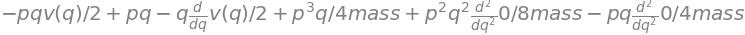

In [3]:
q = Operator(q)
p = Operator(p)
test = (p*q+q*p)/2
time_deriv(test, 1)

In [8]:
def time_deriv(var, order = 1):
    pq_s = Symbol("pq_s")
    aux = Operator(Function("f")(q))
    pq_s = (Operator(p)*Operator(q)+Operator(q)*Operator(p))/2
    
    h1 = expand(ham(p, q)*Operator(var**order)*aux-Operator(var**order)*ham(p, q)*aux)

    
    if var == V:
        der = f'((p)*(Derivative(V, q, {order}+1))+(Derivative(V, q, {order}+1))*(p))/2/m'
    
    if var == p:
        p1 = lin_mom(q, order)
        h1 = (str(simplify(h1)).replace("p", str(Operator(p1))))       
    
    else:
        h1 = str(expand(comm_1(ham(p, q), Operator(var**order), f(q))))
        h1 = h1.replace("pq_s", "((p*q+q*p))/2")


    
    start_points = []
    end_points = []

    start = 0

    s = h1.find("Derivative(1, q)", start)
    while s != -1:
        s = h1.find("Derivative(1, q)", start)
                
        if var == pq_s:
            start = s + len(f"Derivative(1, q) ")
        else:
            start = s + len(f"Derivative(1, q)")
        
        start_points.append(s)
        if s == -1:
            break
               
        if var == pq_s:
            e = h1.find(" ", start + 1)
        else:
            e = h1.find("f(q)", start) + 4            
        
        end_points.append(e)
    
   
    if start_points[-1] == -1:
        start_points.remove(start_points[-1])
    
    new_derivative_function = []
    replace_spot = []

    for i in range(len(start_points)):
        func = h1[start_points[i]:end_points[i]]
        func = start_points[i] + len(f"Derivative(1, q)")
        func1 = h1.find("*", func, end_points[i])

        repl = h1[start_points[i]:end_points[i]].find("1") + start_points[i]
        replace_spot.append(repl)

        
        if var == p:
            new_func = h1[func1:end_points[i]]
            new_derivative_function.append(new_func)    

        else:
            new_func = h1[func1 - 3:end_points[i]]
            new_derivative_function.append(new_func)

    temp = h1.split(" ")

    position_list = []
    temp_list = []


    for i in range(len(temp)):
        if var == p:
            st = 1
        else:
            st = 0
            
        for r in range(st, len(new_derivative_function)):

            if temp[i].find(new_derivative_function[r]) != -1:
                temp[i] = temp[i].replace(new_derivative_function[r], "")

        if temp[i].find("Derivative") == -1:
            continue

        else:
            position = temp[i].find("1,")
            if position != -1:
                position_list.append(position)
                temp_list.append(i)


    TL = len(temp_list) - 1
    nested_list = []
    while TL > -1: 
        r = [temp_list[TL], position_list[TL]]
        nested_list.append(r) 
        TL -= 1 
        if TL == -1:
            break

    nested_list.reverse()

    if var == p:
        for i in range(len(nested_list)):
            temp[nested_list[i][0]] = \
                temp[nested_list[i][0]].replace(temp[nested_list[i][0]][nested_list[i][1]], new_derivative_function[i][1:])  
    
    else:
        for i in range(len(nested_list)):
            temp[nested_list[i][0]] = \
                temp[nested_list[i][0]].replace(temp[nested_list[i][0]][nested_list[i][1]], "1/" + new_derivative_function[i][1:])
        
        
    string = " ".join(temp)
    string = string.replace("v(q)*p*q*f(q)", "f(q)")
    if "(*" in string:
        string = string.replace("(*", "(")
    s = sympify(string)
    s1 = expand(s.doit())
    if var == p:
        repl = 1
        if order == 2:
            s1 = -s1/2
    else:
        repl = 0
    s1 = str(s1).replace("p*q*f(q)*v(q)", "q*Derivative(v(q), q)")
    s2 = str(s1).replace("hbar*i", "1").replace("I", "1").replace("f(q)", f"{repl}").replace(f"hbar**2*i**2*Derivative({repl}, q)", "p").replace(f"Derivative({repl}, q)", "p").replace("hbar**2*i**2", "1").replace("Derivative(v(q), (q, 2))", "0")
  
        
    if var == V:
        return sympify(der)    #/(i*hbar)
    if var == p:
        return -sympify(s2)
    else:
        return sympify(s2)              #/(i*hbar)

In [13]:
(time_deriv(p*q, 1))

THIS IS NEW DERIVATIVE FUNCTION: 
['/(2*mass)*p*q*f(q)', '/(2*mass)*f(q)']
THIS IS STRING: --hbar*i*Derivative(-hbar*i*Derivative(1/(2*mass)*p*q*f(q), q), q) - f(q) + p*q*-hbar*i*Derivative(-hbar*i*Derivative(1/(2*mass)*f(q), q), q) + p*q*v(q)*f(q)
THIS IS s: -hbar*i*p*q*Derivative(-hbar*i*Derivative(f(q)/(2*mass), q), q) + hbar*i*Derivative(-hbar*i*Derivative(p*q*f(q)/(2*mass), q), q) + p*q*f(q)*v(q) - f(q)


# THIS WORKS 

In [5]:
aux = Operator(f(q))

var = q
order = 1
def time_deriv(var, order = 1):
    aux = f(q)
    
    if var == p:
        h1 = expand(Operator(var**order)*ham(p, q)*aux - ham(p, q)*Operator(var**order)*aux)
        h2 = str(h1).replace("/(2*mass)", "*0")

        if order == 1:
            str_repl = "p"
        else:
            str_repl = f"p**{order}"
        h3 = h2.replace(str_repl, f"{lin_mom(q, order)}")

        h1 = str(h3)
    else:
        h1 = str(comm_1(Operator(var**order), ham(p, q), f(q)))


    pq_s = Symbol("pq_s")

    start_points = []
    end_points = []

    start = 0

    s = h1.find("Derivative(1, q)", start)
    while s != -1:
        s = h1.find("Derivative(1, q)", start)

        if var == pq_s:
            start = s + len(f"Derivative(1, q) ")
        else:
            start = s + len(f"Derivative(1, q)")

        start_points.append(s)
        if s == -1:
            break

        if var == pq_s:
            e = h1.find(" ", start + 1)
        else:
            e = h1.find("f(q)", start) + 4            

        end_points.append(e)

    if start_points[-1] == -1:
        start_points.remove(start_points[-1])

    new_derivative_function = []
    replace_spot = []

    for i in range(len(start_points)):
        func = h1[start_points[i]:end_points[i]]
        func = start_points[i] + len(f"Derivative(1, q)")
        func1 = h1.find("*", func, end_points[i])

        repl = h1[start_points[i]:end_points[i]].find("1") + start_points[i]
        replace_spot.append(repl)


        if var == p:
            new_func = h1[func1:end_points[i]]
            new_derivative_function.append(new_func)    

        else:
            new_func = h1[func1 - 3:end_points[i]]
            new_derivative_function.append(new_func)

    temp = h1.split(" ")

    position_list = []
    temp_list = []


    for i in range(len(temp)):
        if var == p:
            st = 1
        else:
            st = 0

        for r in range(st, len(new_derivative_function)):

            if temp[i].find(new_derivative_function[r]) != -1:
                temp[i] = temp[i].replace(new_derivative_function[r], "")

        if temp[i].find("Derivative") == -1:
            continue

        else:
            position = temp[i].find("1,")
            if position != -1:
                position_list.append(position)
                temp_list.append(i)


    TL = len(temp_list) - 1
    nested_list = []
    while TL > -1: 
        r = [temp_list[TL], position_list[TL]]
        nested_list.append(r) 
        TL -= 1 
        if TL == -1:
            break

    nested_list.reverse()

    if var == p:
        for i in range(len(nested_list)):
            temp[nested_list[i][0]] = \
                temp[nested_list[i][0]].replace(temp[nested_list[i][0]][nested_list[i][1]], new_derivative_function[i][1:])  

    else:
        for i in range(len(nested_list)):
            temp[nested_list[i][0]] = \
                temp[nested_list[i][0]].replace(temp[nested_list[i][0]][nested_list[i][1]], "1/" + new_derivative_function[i][1:])


    string = " ".join(temp)
    string = string.replace("v(q)*p*q*f(q)", "f(q)")
    if "(*" in string:
        string = string.replace("(*", "(")
    s = sympify(string)

    s1 = expand(s.doit())

    if var == p:
        repl = 1
    #    s1 = s1/order
    else:
        repl = 0
    s1 = str(s1).replace("p*q*f(q)*v(q)", "-q*Derivative(v(q), q)")
    s2 = str(s1).replace("Derivative(f(q), q)", "p").replace("Derivative(f(q), (q, 2))", "p**2").replace("f(q)", f"{repl}")
    #s3 = str(s2)#.replace("hbar*i", "1")#.replace(f"Derivative({repl}, q)", "p")


    if var == p and order > 1:
        s2 = s2.replace(f"Derivative(v(q), (q, {order}))", "0")

    s4 = str(s2).replace("hbar", "1").replace("i**2", "-1").replace("i*", "1*")

    if var == V:
        return (sympify(der))    #/(i*hbar)
    if var == p:
        return (sympify(s4))
    else:
        return (sympify(s4))              #/(i*hbar)

In [7]:
time_deriv(test, 1)

# ------------------------

In [14]:
def symmetrize(expr):
    """
    Args:
        expr: The expression of interest.
        
    Returns:
        The symmetrized version of the expression of interest.
    """
#    p, x2, x, px, xp = symbols("p, x2, x, px, xp")
    expr1 = str(expr)
    expr1 = expr1.replace("p*x2", "(x2*p-2*x*x*p+2*x*px)").replace("p*x", "xp").replace("px", "xp")
    return sympify(expr1)